In [207]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [208]:
from fastbook import *
from utils import *
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.metrics import accuracy_score, roc_auc_score 
import datetime


path = Path('/Users/baranserajelahi/Codes/fraud-detection-pytorch-scikit-fastai/data')
Path.BASE_PATH = path
pd.options.display.max_rows = 200
pd.options.display.max_columns = 120

## Data processing steps

### Assign order to ordinals

There does not appear to be any identifiable ordinal variables amoung the catergorical variables in the dataset.

### Handling dates

The only place where there is datetime info is the TransactionDT collumn. It's possible to turn this delta into a datetime (assuming units are seconds as indicated by some on the disscussion board) by choosing a starting point. [example](https://www.kaggle.com/nroman/eda-for-cis-fraud-detection). I will train my first models without doing that.

Next need to add datepart (i think it's important for parts of this that the correct start date is used)

#### With cont_cat_split

In [209]:
train_ss = pd.read_csv(path/'train_ss.csv', index_col=[0], low_memory=False)

(0.0, 200.0)

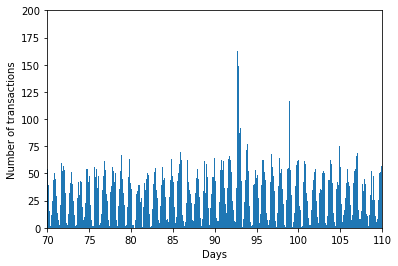

In [210]:
plt.hist(train_ss['TransactionDT'] / (3600*24), bins=1800)
plt.xlim(70, 78 + 32)
plt.xlabel('Days')
plt.ylabel('Number of transactions')
plt.ylim(0,200)

In [211]:
train_ss['TransactionDT']

57195      1316341
312877     7780176
195195     4394717
21600       572518
12253       348181
            ...   
224165     5277204
322952     8012992
449491    11466467
343893     8470758
125898     2493922
Name: TransactionDT, Length: 59054, dtype: int64

In [212]:
# The rows with TransactionDT <= 12579058 comprise the first 80% of the data (approximately)
dep_var = 'isFraud'
cut_off = math.floor((train_ss['TransactionDT'].max() - train_ss['TransactionDT'].min())*0.8)
cut_off

cond = train_ss['TransactionDT'] <= cut_off
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [213]:
START_DATE = '2017-12-01'

In [214]:
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
train_ss['TransactionDT'] = train_ss['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

In [215]:
train_ss['TransactionDT']

57195    2017-12-16 05:39:01
312877   2018-03-01 01:09:36
195195   2018-01-20 20:45:17
21600    2017-12-07 15:01:58
12253    2017-12-05 00:43:01
                 ...        
224165   2018-01-31 01:53:24
322952   2018-03-03 17:49:52
449491   2018-04-12 17:07:47
343893   2018-03-09 00:59:18
125898   2017-12-29 20:45:22
Name: TransactionDT, Length: 59054, dtype: datetime64[ns]

In [216]:
train_ss = add_datepart(train_ss, 'TransactionDT', drop=False, time=True)

In [172]:
train_ss.head()

,TransactionID,isFraud,TransactionDT,TransactionDTWeek,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionDTYear,TransactionDTMonth,TransactionDTDay,TransactionDTDayofweek,TransactionDTDayofyear,TransactionDTIs_month_end,TransactionDTIs_month_start,TransactionDTIs_quarter_end,TransactionDTIs_quarter_start,TransactionDTIs_year_end,TransactionDTIs_year_start,TransactionDTHour,TransactionDTMinute,TransactionDTSecond,TransactionDTElapsed
57195,3044195,0,2017-12-16 05:39:01,50,418.95,W,4806,490.0,150.0,visa,226.0,debit,315.0,87.0,NaN,NaN,aol.com,NaN,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,472.0,NaN,463.0,288.0,288.0,NaN,NaN,NaN,NaN,288.0,NaN,NaN,NaN,NaN,288.0,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,12,16,5,350,False,False,False,False,False,False,5,39,1,1513402741
312877,3299877,0,2018-03-01 01:09:36,9,59.00,W,12577,268.0,150.0,visa,166.0,debit,325.0,87.0,4.0,NaN,gmail.com,NaN,5.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,12.0,4.0,0.0,NaN,NaN,330.0,196.0,NaN,NaN,NaN,NaN,400.0,301.0,NaN,NaN,NaN,330.0,T,T,T,M0,F,T,F,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,3,1,3,60,False,True,False,False,False,False,1,9,36,1519866576
195195,3182195,1,2018-01-20 20:45:17,3,29.00,W,4693,417.0,150.0,visa,195.0,debit,308.0,87.0,1.0,NaN,yahoo.com,NaN,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,8.0,1.0,51.0,51.0,0.0,51.0,0.0,NaN,NaN,NaN,NaN,51.0,51.0,NaN,NaN,NaN,51.0,T,T,T,M0,T,F,F,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1,20,5,20,False,False,False,False,False,False,20,45,17,1516481117
21600,3008600,0,2017-12-07 15:01:58,49,24.00,W,7919,194.0,150.0,mastercard,202.0,debit,123.0,87.0,0.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,T,T,M1,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,12,7,3,341,False,False,False,False,False,False,15,1,58,1512658918
12253,2999253,0,2017-12-05 00:43:01,49,57.95,W,13108,215.0,150.0,visa,226.0,debit,191.0,87.0,27.0,NaN,NaN,NaN,2.0,2.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,0.0,3.0,0.0,18.0,2.0,484.0,484.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,483.0,NaN,NaN,NaN,NaN,NaN,T,T,T,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,12,5,1,339,False,False,False,False,False,False,0,43,1,1512434581


In [173]:
dep_var = 'isFraud'
procs = [Categorify, FillMissing]

In [174]:
cont,cat = cont_cat_split(train_ss, max_card=9000, dep_var=dep_var)

In [175]:
cont

['TransactionID',
 'TransactionAmt',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
 'id_13',
 'id_14',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_24',
 'id_25',
 'id_26',
 'id_32']

In [176]:
cat

['TransactionDT',
 'TransactionDTWeek',
 'ProductCD',
 'card1',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo',
 'TransactionDTYear',
 'TransactionDTMonth',
 'TransactionDTDay',
 'TransactionDTDayofweek',
 'TransactionDTDayofyear',
 'TransactionDTIs_month_end',
 'TransactionDTIs_month_start',
 'TransactionDTIs_quarter_end',
 'TransactionDTIs_quarter_start',
 'TransactionDTIs_year_end',
 'TransactionDTIs_year_start',
 'TransactionDTHour',
 'TransactionDTMinute',
 'TransactionDTSecond',
 'TransactionDTElapsed']

In [177]:
to = TabularPandas(train_ss, procs, cat, cont, y_names=dep_var, splits=splits)

In [178]:
to.show()

,TransactionDT,TransactionDTWeek,ProductCD,card1,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionDTYear,TransactionDTMonth,TransactionDTDay,TransactionDTDayofweek,TransactionDTDayofyear,TransactionDTIs_month_end,TransactionDTIs_month_start,TransactionDTIs_quarter_end,TransactionDTIs_quarter_start,TransactionDTIs_year_end,TransactionDTIs_year_start,TransactionDTHour,TransactionDTMinute,TransactionDTSecond,TransactionDTElapsed,card2_na,card3_na,card5_na,addr1_na,addr2_na,dist1_na,dist2_na,D1_na,D2_na,D3_na,D4_na,D5_na,D6_na,D7_na,D8_na,D9_na,D10_na,D11_na,D12_na,D13_na,D14_na,D15_na,id_01_na,id_02_na,id_03_na,id_04_na,id_05_na,id_06_na,id_07_na,id_08_na,id_09_na,id_10_na,id_11_na,id_13_na,id_14_na,id_17_na,id_18_na,id_19_na,id_20_na,id_21_na,id_22_na,id_24_na,id_25_na,id_26_na,id_32_na,TransactionID,TransactionAmt,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32,isFraud
57195,2017-12-16 05:39:01,50,W,4806,visa,debit,aol.com,#na#,#na#,#na#,#na#,#na#,#na#,T,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2017,12,16,5,350,False,False,False,False,False,False,5,39,1,1513402741,False,False,False,False,False,True,True,False,True,False,False,False,True,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,3044195,418.950012,490.0,150.0,226.0,315.0,87.0,8.0,36.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,472.0,97.0,463.0,288.0,288.0,0.0,0.0,39.208332,0.666666,288.0,36.0,0.0,0.0,0.0,288.0,-5.0,123602.0,0.0,0.0,0.0,0.0,14.0,-33.0,0.0,0.0,100.0,52.0,-300.0,166.0,15.0,341.0,469.0,252.0,14.0,11.0,321.0,149.0,24.0,0
312877,2018-03-01 01:09:36,9,W,12577,visa,debit,gmail.com,#na#,T,T,T,M0,F,T,F,T,T,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2018,3,1,3,60,False,True,False,False,False,False,1,9,36,1519866576,False,False,False,False,False,False,True,False,True,True,False,False,True,True,True,True,False,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,3299877,59.000000,268.0,150.0,166.0,325.0,87.0,4.0,36.0,5.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,12.0,4.0,0.0,97.0,8.0,330.0,196.0,0.0,0.0,39.208332,0.666666,400.0,301.0,0.0,0.0,0.0,330.0,-5.0,123602.0,0.0,0.0,0.0,0.0,14.0,-33.0,0.0,0.0,100.0,52.0,-300.0,166.0,15.0,341.0,469.0,252.0,14.0,11.0,321.0,149.0,24.0,0
195195,2018-01-20 20:45:17,3,W,4693,visa,debit,yahoo.com,#na#,T,T,T,M0,T,F,F,T,T,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2018,1,20,5,20,False,False,False,False,False,False,20,45,17,1516481117,False,False,False,False,False,False,True,False,False,False,False,False,True,True,True,True,False,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,3182195,29.000000,417.0,150.0,195.0,308.0,87.0,1.0,36.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,8.0,1.0,51.0,51.0,0.0,51.0,0.0,0.0,0.0,39.208332,0.666666,51.0,51.0,0.0,0.0,0.0,51.0,-5.0,123602.0,0.0,0.0,0.0,0.0,14.0,-33.0,0.0,0.0,100.0,52.0,-300.0,166.0,15.0,341.0,469.0,252.0,14.0,11.0,321.0,149.0,24.0,1
21600,2017-12-07 15:01:58,49,W,7919,mastercard,debit,#na#,#na#,T,T,T,M1,T,F,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2017,12,7,3,341,False,False,False,False,False,False,15,1,58,1512658918,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,False,False,True

In [179]:
to.items

,TransactionID,isFraud,TransactionDT,TransactionDTWeek,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,...,TransactionDTYear,TransactionDTMonth,TransactionDTDay,TransactionDTDayofweek,TransactionDTDayofyear,TransactionDTIs_month_end,TransactionDTIs_month_start,TransactionDTIs_quarter_end,TransactionDTIs_quarter_start,TransactionDTIs_year_end,TransactionDTIs_year_start,TransactionDTHour,TransactionDTMinute,TransactionDTSecond,TransactionDTElapsed,card2_na,card3_na,card5_na,addr1_na,addr2_na,dist1_na,dist2_na,D1_na,D2_na,D3_na,D4_na,D5_na,D6_na,D7_na,D8_na,D9_na,D10_na,D11_na,D12_na,D13_na,D14_na,D15_na,id_01_na,id_02_na,id_03_na,id_04_na,id_05_na,id_06_na,id_07_na,id_08_na,id_09_na,id_10_na,id_11_na,id_13_na,id_14_na,id_17_na,id_18_na,id_19_na,id_20_na,id_21_na,id_22_na,id_24_na,id_25_na,id_26_na,id_32_na
57195,3044195,0,5714,20,418.950012,5,1233,490.0,150.0,4,226.0,3,315.0,87.0,8.0,36.0,3,0,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,472.0,97.0,463.0,288.0,288.0,0.0,0.0,39.208332,0.666666,288.0,36.0,0.0,0.0,0.0,288.0,0,0,0,0,0,2,0,0,0,-5.0,123602.0,0.0,0.0,...,1,5,16,6,130,1,1,1,1,1,1,6,40,2,5714,1,1,1,1,1,2,2,1,2,1,1,1,2,2,2,2,1,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
312877,3299877,0,31055,9,59.000000,5,3740,268.0,150.0,4,166.0,3,325.0,87.0,4.0,36.0,17,0,5.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,12.0,4.0,0.0,97.0,8.0,330.0,196.0,0.0,0.0,39.208332,0.666666,400.0,301.0,0.0,0.0,0.0,330.0,2,2,2,1,1,2,1,2,2,-5.0,123602.0,0.0,0.0,...,2,3,1,4,60,1,2,1,1,1,1,2,10,37,31055,1,1,1,1,1,1,2,1,2,2,1,1,2,2,2,2,1,1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
195195,3182195,1,19454,3,29.000000,5,1196,417.0,150.0,4,195.0,3,308.0,87.0,1.0,36.0,54,0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,8.0,1.0,51.0,51.0,0.0,51.0,0.0,0.0,0.0,39.208332,0.666666,51.0,51.0,0.0,0.0,0.0,51.0,2,2,2,1,2,1,1,2,2,-5.0,123602.0,0.0,0.0,...,2,1,20,6,20,1,1,1,1,1,1,21,46,18,19454,1,1,1,1,1,1,2,1,1,1,1,1,2,2,2,2,1,1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
21600,3008600,0,2127,19,24.000000,5,2236,194.0,150.0,3,202.0,3,123.0,87.0,0.0,36.0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,24.0,9.0,0.0,0.0,39.208332,0.666666,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2,2,2,1,0,0,0,-5.0,123602.0,0.0,0.0,...,1,5,7,4,121,1,1,1,1,1,1,16,2,59,2127,1,1,1,1,1,1,2,1,2,2,2,2,2,2,2,2,1,1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
12253,2999253,0,1225,19,57.950001,5,3916,215.0,150.0,4,226.0,3,191.0,87.0,27.0,36.0,0,0,2.0,2.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,0.0,3.0,0.0,18.0,2.0,484.0,484.0,7.0,24.0,9.0,0.0,0.0,39.208332,0.666666,483.0,36.0,0.0,0.0,0.0,48.0,2,2,2,0,0,1,0,0,0,-5.0,123602.0,0.0,0.0,...,1,5,5,2,119,1,1,1,1,1,1,1,44,2,1225,1,1,1,1,1,1,2,1,1,1,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585191,3572191,0,0,0,77.000000,5,2796,313.0,150.0,4,226.0,3,299.0,87.0,8.0,36.0,20,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,9.0,0.0,0.0,39.208332,0.666666,0.0,0.0,0.0,0.0,0.0,0.0,2,2,1,1,1,2,1,1,2,-5.0,123602.0,0.0,0.0,...,2,0,31,4,0,2,1,1,1,1,1,1,42,14,58333,1,1,1,1,1,2,2,1,2,2,1,2,2,2,2,2,1,1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
582517,3569517,0,0,0,524.950012,5,576,100.0,150.0,4,226.0,3,330.0,87.0,219.0,36.0,54,0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0

In [180]:
def m_roc(y, xs):
    preds = m.predict_proba(xs)
    preds_isFraud = preds[:,1]
    return roc_auc_score(y, preds_isFraud)

In [181]:
xs, y             = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [184]:
m = RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=1000,  criterion='entropy', 
                           class_weight='balanced', n_jobs=-1).fit(xs, y)
m_roc(y, xs), m_roc(valid_y, valid_xs)

(1.0, 0.8469800212040808)

In [185]:
m = RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=1000, criterion='entropy', 
                           class_weight='balanced', max_leaf_nodes=50,
                            max_features='sqrt', n_jobs=-1).fit(xs, y)
m_roc(y, xs), m_roc(valid_y, valid_xs)

(0.8948748732030588, 0.8314320981916162)

In [176]:
def rf_feature_importance(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feature_importance(m, xs)
fi[:30]

,cols,imp
111,D3,0.043247
99,C5,0.040354
107,C13,0.038213
95,C1,0.037034
108,C14,0.036412
110,D2,0.030095
102,C8,0.029982
98,C4,0.028099
6,R_emaildomain,0.027811
104,C10,0.026542


<AxesSubplot:ylabel='cols'>

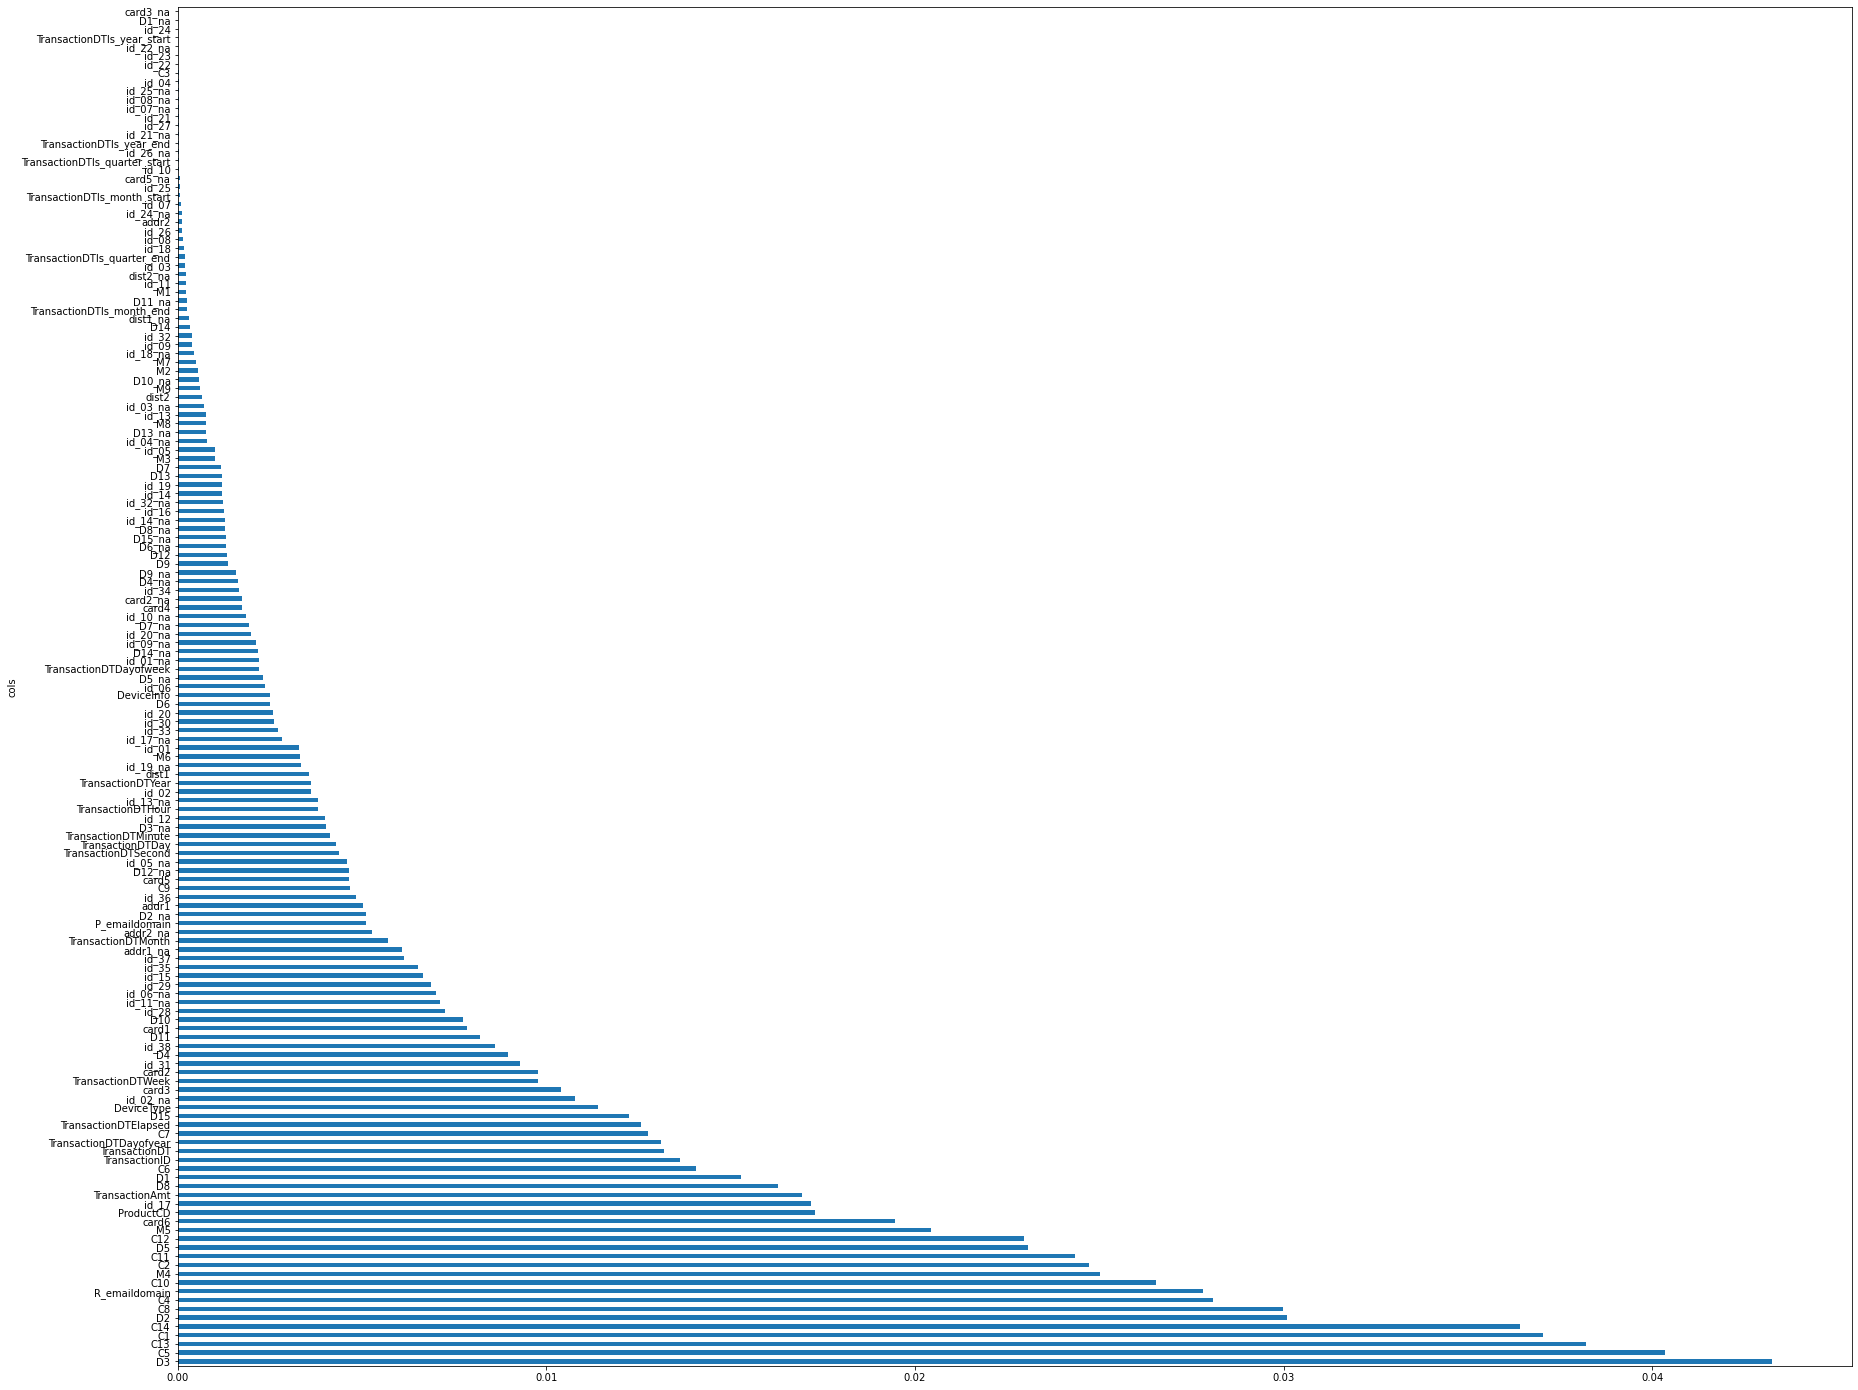

In [177]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(30,25), legend=False)
                   
plot_fi(fi)

In [179]:
to_keep = fi[fi.imp>0.0001].cols
print(f' n_features: {len(to_keep)}')

xs_imp       = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m =  RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=200, criterion='entropy', 
                           class_weight='balanced', max_leaf_nodes=50,
                            max_features='sqrt', n_jobs=-1).fit(xs_imp, y)
m_roc(y, xs_imp), m_roc(valid_y, valid_xs_imp)

 n_features: 132


(0.8962949433046038, 0.8328740184297599)

In [180]:
to_keep = fi[fi.imp>0.001].cols
print(f' n_features: {len(to_keep)}')

xs_imp       = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m =  RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=1000, criterion='entropy', 
                           class_weight='balanced', max_leaf_nodes=50,
                            max_features='sqrt', n_jobs=-1).fit(xs_imp, y)
m_roc(y, xs_imp), m_roc(valid_y, valid_xs_imp)

 n_features: 105


(0.8975359639813953, 0.834289760790294)

In [189]:
to_keep = fi[fi.imp>0.002].cols
print(f' n_features: {len(to_keep)}')

xs_imp       = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m =  RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=200, criterion='entropy', 
                           class_weight='balanced', max_leaf_nodes=50,
                            max_features='sqrt', n_jobs=-1).fit(xs_imp, y)
m_roc(y, xs_imp), m_roc(valid_y, valid_xs_imp)

 n_features: 83


(0.8977135982347176, 0.8314930018252392)

In [190]:
to_keep = fi[fi.imp>0.003].cols
print(f' n_features: {len(to_keep)}')

xs_imp       = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m =  RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=200, criterion='entropy', 
                           class_weight='balanced', max_leaf_nodes=50,
                            max_features='sqrt', n_jobs=-1).fit(xs_imp, y)
m_roc(y, xs_imp), m_roc(valid_y, valid_xs_imp)

 n_features: 71


(0.8979523872466395, 0.832333097999556)

In [192]:
to_keep = fi[fi.imp>0.004].cols
print(f' n_features: {len(to_keep)}')

xs_imp       = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m =  RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=200, criterion='entropy', 
                           class_weight='balanced', max_leaf_nodes=50,
                            max_features='sqrt', n_jobs=-1).fit(xs_imp, y)
m_roc(y, xs_imp), m_roc(valid_y, valid_xs_imp)

 n_features: 62


(0.8971900997122533, 0.8330252090290172)

In [193]:
to_keep = fi[fi.imp>0.005].cols
print(f' n_features: {len(to_keep)}')

xs_imp       = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m =  RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=200, criterion='entropy', 
                           class_weight='balanced', max_leaf_nodes=50,
                            max_features='sqrt', n_jobs=-1).fit(xs_imp, y)
m_roc(y, xs_imp), m_roc(valid_y, valid_xs_imp)

 n_features: 53


(0.897280725113521, 0.8339921877733818)

In [194]:
to_keep = fi[fi.imp>0.006].cols
print(f' n_features: {len(to_keep)}')

xs_imp       = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m =  RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=200, criterion='entropy', 
                           class_weight='balanced', max_leaf_nodes=50,
                            max_features='sqrt', n_jobs=-1).fit(xs_imp, y)
m_roc(y, xs_imp), m_roc(valid_y, valid_xs_imp)

 n_features: 48


(0.8953510179122481, 0.8326082328356598)

In [195]:
to_keep = fi[fi.imp>0.007].cols
print(f' n_features: {len(to_keep)}')

xs_imp       = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m =  RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=200, criterion='entropy', 
                           class_weight='balanced', max_leaf_nodes=50,
                            max_features='sqrt', n_jobs=-1).fit(xs_imp, y)
m_roc(y, xs_imp), m_roc(valid_y, valid_xs_imp)

 n_features: 43


(0.8971573632893597, 0.8341452482210396)

In [196]:
to_keep = fi[fi.imp>0.008].cols
print(f' n_features: {len(to_keep)}')

xs_imp       = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m =  RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=200, criterion='entropy', 
                           class_weight='balanced', max_leaf_nodes=50,
                            max_features='sqrt', n_jobs=-1).fit(xs_imp, y)
m_roc(y, xs_imp), m_roc(valid_y, valid_xs_imp)

 n_features: 38


(0.8968266486118209, 0.8334957430229947)

In [207]:
to_keep = fi[fi.imp>0.009].cols
print(f' n_features: {len(to_keep)}')

xs_imp       = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m =  RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=200, criterion='entropy', 
                           class_weight='balanced', max_leaf_nodes=50,
                            max_features='sqrt', n_jobs=-1).fit(xs_imp, y)
m_roc(y, xs_imp), m_roc(valid_y, valid_xs_imp)

 n_features: 35


(0.894809382214048, 0.8318708447627817)

In [205]:
xs_imp

,D3,C5,C13,C1,C14,D2,C8,C4,R_emaildomain,C10,M4,C2,C11,D5,C12,M5,card6,ProductCD,id_17,TransactionAmt,D8,D1,C6,TransactionID,TransactionDT,TransactionDTDayofyear,C7,TransactionDTElapsed,D15,DeviceType,id_02_na,card3,TransactionDTWeek,card2,id_31
57195,463.0,2.0,2.0,2.0,2.0,97.0,0.0,0.0,0,0.0,0,1.0,1.0,288.0,0.0,0,3,5,166.0,418.950012,39.208332,472.0,1.0,3044195,5714,350,0.0,5714,288.0,0,2,150.0,20,490.0,0
312877,8.0,1.0,12.0,5.0,4.0,97.0,0.0,0.0,0,0.0,1,3.0,1.0,196.0,0.0,1,3,5,166.0,59.000000,39.208332,0.0,2.0,3299877,31055,60,0.0,31055,330.0,0,2,150.0,9,268.0,0
195195,0.0,0.0,8.0,1.0,1.0,51.0,0.0,0.0,0,0.0,1,2.0,2.0,0.0,0.0,2,3,5,166.0,29.000000,39.208332,51.0,1.0,3182195,19454,20,0.0,19454,51.0,0,2,150.0,3,417.0,0
21600,8.0,0.0,1.0,1.0,1.0,97.0,0.0,0.0,0,0.0,2,1.0,1.0,9.0,0.0,2,3,5,166.0,24.000000,39.208332,0.0,0.0,3008600,2127,341,0.0,2127,0.0,0,2,150.0,19,194.0,0
12253,7.0,3.0,18.0,2.0,2.0,484.0,0.0,0.0,0,0.0,0,2.0,3.0,9.0,0.0,0,3,5,166.0,57.950001,39.208332,484.0,1.0,2999253,1225,339,0.0,1225,48.0,0,2,150.0,19,215.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224165,8.0,0.0,2.0,2.0,2.0,97.0,2.0,1.0,55,2.0,1,2.0,2.0,262.0,2.0,0,2,1,225.0,28.018000,39.208332,0.0,1.0,3211165,22257,31,1.0,22257,0.0,1,1,185.0,5,176.0,74
322952,8.0,0.0,0.0,1.0,0.0,97.0,1.0,1.0,17,1.0,3,2.0,2.0,0.0,2.0,0,2,1,166.0,123.498001,39.208332,583.0,1.0,3309952,32093,62,1.0,32093,0.0,0,2,150.0,9,490.0,0
449491,1.0,1.0,20.0,1.0,1.0,528.0,0.0,0.0,0,0.0,1,1.0,1.0,1.0,0.0,2,3,5,166.0,59.000000,39.208332,528.0,1.0,3436491,44783,102,0.0,44783,529.0,0,2,150.0,15,420.0,0
343893,8.0,0.0,1.0,1.0,1.0,97.0,0.0,1.0,2,0.0,3,1.0,1.0,9.0,1.0,0,3,1,166.0,31.902000,39.208332,0.0,1.0,3330893,34196,68,1.0,34196,0.0,0,2,185.0,10,545.0,0


In [206]:
to_keep = fi[fi.imp>0.015].cols
print(f' n_features: {len(to_keep)}')

xs_imp       = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m =  RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=200, criterion='entropy', 
                           class_weight='balanced', max_leaf_nodes=50,
                            max_features='sqrt', n_jobs=-1).fit(xs_imp, y)
m_roc(y, xs_imp), m_roc(valid_y, valid_xs_imp)

 n_features: 22


(0.8864829670934178, 0.8316435246214959)

#### With manual assignment of conts and cats

In [186]:
dep_var = 'isFraud'
procs = [Categorify, FillMissing]

In [187]:
cat = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
       'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 
       'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 
       'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 
       'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38',
       'TransactionDTWeek', 'TransactionDTYear', 'TransactionDTMonth', 'TransactionDTDay',
       'TransactionDTDayofweek', 'TransactionDTDayofyear', 'TransactionDTIs_month_end',
       'TransactionDTIs_month_start', 'TransactionDTIs_quarter_end', 'TransactionDTIs_quarter_start',
       'TransactionDTIs_year_end', 'TransactionDTIs_year_start', 'TransactionDTHour',
       'TransactionDTMinute', 'TransactionDTSecond', 'TransactionDTElapsed', 'TransactionDT'] 
cont = ['TransactionID', 'TransactionAmt',
        'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 
        'C10', 'C11','C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 
        'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'id_01', 'id_02', 
        'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 
        'id_11']


In [188]:
to = TabularPandas(train_ss, procs, cat, cont, y_names=dep_var, splits=splits)

In [189]:
to.show()

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,TransactionDTWeek,TransactionDTYear,TransactionDTMonth,TransactionDTDay,TransactionDTDayofweek,TransactionDTDayofyear,TransactionDTIs_month_end,TransactionDTIs_month_start,TransactionDTIs_quarter_end,TransactionDTIs_quarter_start,TransactionDTIs_year_end,TransactionDTIs_year_start,TransactionDTHour,TransactionDTMinute,TransactionDTSecond,TransactionDTElapsed,TransactionDT,dist1_na,dist2_na,D1_na,D2_na,D3_na,D4_na,D5_na,D6_na,D7_na,D8_na,D9_na,D10_na,D11_na,D12_na,D13_na,D14_na,D15_na,id_01_na,id_02_na,id_03_na,id_04_na,id_05_na,id_06_na,id_07_na,id_08_na,id_09_na,id_10_na,id_11_na,TransactionID,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,isFraud
57195,W,4806,490,150,visa,226,debit,315,87,aol.com,#na#,#na#,#na#,#na#,#na#,#na#,T,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,50,2017,12,16,5,350,False,False,False,False,False,False,5,39,1,1513402741,2017-12-16 05:39:01,True,True,False,True,False,False,False,True,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,3044195,418.950012,8.0,36.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,472.0,97.0,463.0,288.0,288.0,0.0,0.0,39.208332,0.666666,288.0,36.0,0.0,0.0,0.0,288.0,-5.0,123602.0,0.0,0.0,0.0,0.0,14.0,-33.0,0.0,0.0,100.0,0
312877,W,12577,268,150,visa,166,debit,325,87,gmail.com,#na#,T,T,T,M0,F,T,F,T,T,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,9,2018,3,1,3,60,False,True,False,False,False,False,1,9,36,1519866576,2018-03-01 01:09:36,False,True,False,True,True,False,False,True,True,True,True,False,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,3299877,59.000000,4.0,36.0,5.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,12.0,4.0,0.0,97.0,8.0,330.0,196.0,0.0,0.0,39.208332,0.666666,400.0,301.0,0.0,0.0,0.0,330.0,-5.0,123602.0,0.0,0.0,0.0,0.0,14.0,-33.0,0.0,0.0,100.0,0
195195,W,4693,417,150,visa,195,debit,308,87,yahoo.com,#na#,T,T,T,M0,T,F,F,T,T,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,3,2018,1,20,5,20,False,False,False,False,False,False,20,45,17,1516481117,2018-01-20 20:45:17,False,True,False,False,False,False,False,True,True,True,True,False,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,3182195,29.000000,1.0,36.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,8.0,1.0,51.0,51.0,0.0,51.0,0.0,0.0,0.0,39.208332,0.666666,51.0,51.0,0.0,0.0,0.0,51.0,-5.0,123602.0,0.0,0.0,0.0,0.0,14.0,-33.0,0.0,0.0,100.0,1
21600,W,7919,194,150,mastercard,202,debit,123,87,#na#,#na#,T,T,T,M1,T,F,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,49,2017,12,7,3,341,False,False,False,False,False,False,15,1,58,1512658918,2017-12-07 15:01:58,False,True,False,True,True,True,True,True,True,True,True,False,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,3008600,24.000000,0.0,36.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,24.0,9.0,0.0,0.0,39.208332,0.666666,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,123602.0,0.0,0.0,0.0,0.0,14.0,-33.0,0.0,0.0,100.0,0
12253,W,13108,215,150,visa,226,debit,191,87,#na#,#na#,T,T,T,#na#,#na#,F,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#

In [190]:
to.items

,TransactionID,isFraud,TransactionDT,TransactionDTWeek,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,...,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionDTYear,TransactionDTMonth,TransactionDTDay,TransactionDTDayofweek,TransactionDTDayofyear,TransactionDTIs_month_end,TransactionDTIs_month_start,TransactionDTIs_quarter_end,TransactionDTIs_quarter_start,TransactionDTIs_year_end,TransactionDTIs_year_start,TransactionDTHour,TransactionDTMinute,TransactionDTSecond,TransactionDTElapsed,dist1_na,dist2_na,D1_na,D2_na,D3_na,D4_na,D5_na,D6_na,D7_na,D8_na,D9_na,D10_na,D11_na,D12_na,D13_na,D14_na,D15_na,id_01_na,id_02_na,id_03_na,id_04_na,id_05_na,id_06_na,id_07_na,id_08_na,id_09_na,id_10_na,id_11_na
57195,3044195,0,5714,20,418.950012,5,1233,390,30,4,70,3,68,21,8.0,36.0,3,0,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,472.0,97.0,463.0,288.0,288.0,0.0,0.0,39.208332,0.666666,288.0,36.0,0.0,0.0,0.0,288.0,0,0,0,0,0,2,0,0,0,-5.0,123602.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,16,6,130,1,1,1,1,1,1,6,40,2,5714,2,2,1,2,1,1,1,2,2,2,2,1,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2
312877,3299877,0,31055,9,59.000000,5,3740,168,30,4,40,3,70,21,4.0,36.0,17,0,5.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,12.0,4.0,0.0,97.0,8.0,330.0,196.0,0.0,0.0,39.208332,0.666666,400.0,301.0,0.0,0.0,0.0,330.0,2,2,2,1,1,2,1,2,2,-5.0,123602.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,1,4,60,1,2,1,1,1,1,2,10,37,31055,1,2,1,2,2,1,1,2,2,2,2,1,1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2
195195,3182195,1,19454,3,29.000000,5,1196,317,30,4,51,3,64,21,1.0,36.0,54,0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,8.0,1.0,51.0,51.0,0.0,51.0,0.0,0.0,0.0,39.208332,0.666666,51.0,51.0,0.0,0.0,0.0,51.0,2,2,2,1,2,1,1,2,2,-5.0,123602.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,20,6,20,1,1,1,1,1,1,21,46,18,19454,1,2,1,1,1,1,1,2,2,2,2,1,1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2
21600,3008600,0,2127,19,24.000000,5,2236,94,30,3,57,3,6,21,0.0,36.0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,24.0,9.0,0.0,0.0,39.208332,0.666666,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2,2,2,1,0,0,0,-5.0,123602.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,7,4,121,1,1,1,1,1,1,16,2,59,2127,1,2,1,2,2,2,2,2,2,2,2,1,1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2
12253,2999253,0,1225,19,57.950001,5,3916,115,30,4,70,3,26,21,27.0,36.0,0,0,2.0,2.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,0.0,3.0,0.0,18.0,2.0,484.0,484.0,7.0,24.0,9.0,0.0,0.0,39.208332,0.666666,483.0,36.0,0.0,0.0,0.0,48.0,2,2,2,0,0,1,0,0,0,-5.0,123602.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,5,2,119,1,1,1,1,1,1,1,44,2,1225,1,2,1,1,1,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585191,3572191,0,0,0,77.000000,5,2796,213,30,4,70,3,63,21,8.0,36.0,20,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,9.0,0.0,0.0,39.208332,0.666666,0.0,0.0,0.0,0.0,0.0,0.0,2,2,1,1,1,2,1,1,2,-5.0,123602.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,31,4,0,2,1,1,1,1,1,1,42,14,58333,2,2,1,2,2,1,2,2,2,2,2,1,1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2
582517,3569517,0,0,0,524.950012,5,576,1,30,4,70,3,73,21,219.0,36.0,54,0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0,97.0,8.0,448.0,275.0,0.0,0.0,39.208332,0.666666,486.0,486.0,0.0,0.0,0.0,486.0,2,2,2,0,0,1,1,1,1,-5.0,123602.0,0

In [191]:
def m_roc(y, xs):
    preds = m.predict_proba(xs)
    preds_isFraud = preds[:,1]
    return roc_auc_score(y, preds_isFraud)

In [192]:
xs, y             = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [193]:
m = RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=1000,  criterion='entropy', 
                           class_weight='balanced', n_jobs=-1).fit(xs, y)
m_roc(y, xs), m_roc(valid_y, valid_xs)

(1.0, 0.8506962113398826)

In [194]:
m = RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=1000, criterion='entropy', 
                           class_weight='balanced', max_leaf_nodes=50,
                            max_features='sqrt', n_jobs=-1).fit(xs, y)
m_roc(y, xs), m_roc(valid_y, valid_xs)

(0.8949555379746376, 0.8308732806410054)

### Split TransactionAmt (With datetime handling above)

In [223]:
train_ss['TransactionAmt']

57195     418.950
312877     59.000
195195     29.000
21600      24.000
12253      57.950
           ...   
224165     28.018
322952    123.498
449491     59.000
343893     31.902
125898     54.500
Name: TransactionAmt, Length: 59054, dtype: float64

In [200]:
# train_ss['TransactionAmt'] = np.log(train_ss['TransactionAmt'])

In [234]:
train_ss['TransactionAmt'].str()

AttributeError: Can only use .str accessor with string values!

In [243]:
train_ss

,TransactionID,isFraud,TransactionDT,TransactionDTWeek,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionDTYear,TransactionDTMonth,TransactionDTDay,TransactionDTDayofweek,TransactionDTDayofyear,TransactionDTIs_month_end,TransactionDTIs_month_start,TransactionDTIs_quarter_end,TransactionDTIs_quarter_start,TransactionDTIs_year_end,TransactionDTIs_year_start,TransactionDTHour,TransactionDTMinute,TransactionDTSecond,TransactionDTElapsed
57195,3044195,0,2017-12-16 05:39:01,50,418.950,W,4806,490.0,150.0,visa,226.0,debit,315.0,87.0,NaN,NaN,aol.com,NaN,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,472.0,NaN,463.0,288.0,288.0,NaN,NaN,NaN,NaN,288.0,NaN,NaN,NaN,NaN,288.0,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,12,16,5,350,False,False,False,False,False,False,5,39,1,1513402741
312877,3299877,0,2018-03-01 01:09:36,9,59.000,W,12577,268.0,150.0,visa,166.0,debit,325.0,87.0,4.0,NaN,gmail.com,NaN,5.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,12.0,4.0,0.0,NaN,NaN,330.0,196.0,NaN,NaN,NaN,NaN,400.0,301.0,NaN,NaN,NaN,330.0,T,T,T,M0,F,T,F,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,3,1,3,60,False,True,False,False,False,False,1,9,36,1519866576
195195,3182195,1,2018-01-20 20:45:17,3,29.000,W,4693,417.0,150.0,visa,195.0,debit,308.0,87.0,1.0,NaN,yahoo.com,NaN,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,8.0,1.0,51.0,51.0,0.0,51.0,0.0,NaN,NaN,NaN,NaN,51.0,51.0,NaN,NaN,NaN,51.0,T,T,T,M0,T,F,F,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1,20,5,20,False,False,False,False,False,False,20,45,17,1516481117
21600,3008600,0,2017-12-07 15:01:58,49,24.000,W,7919,194.0,150.0,mastercard,202.0,debit,123.0,87.0,0.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,T,T,M1,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,12,7,3,341,False,False,False,False,False,False,15,1,58,1512658918
12253,2999253,0,2017-12-05 00:43:01,49,57.950,W,13108,215.0,150.0,visa,226.0,debit,191.0,87.0,27.0,NaN,NaN,NaN,2.0,2.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,0.0,3.0,0.0,18.0,2.0,484.0,484.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,483.0,NaN,NaN,NaN,NaN,NaN,T,T,T,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,12,5,1,339,False,False,False,False,False,False,0,43,1,1512434581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224165,3211165,0,2018-01-31 01:53:24,5,28.018,C,3289,176.0,185.0,mastercard,224.0,credit,NaN,NaN,NaN,7.0,yahoo.com.mx,yahoo.com.mx,2.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,NaN,NaN,262.0

In [ ]:
train_ss['TransactionAmtCents'] = train_ss['TransactionAmt']
train_ss['TransactionAmtdDollars'] = train_ss['TransactionAmt']

In [202]:
dep_var = 'isFraud'
procs = [Categorify, FillMissing]

cat = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
       'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 
       'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 
       'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 
       'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38',
       'TransactionDTWeek', 'TransactionDTYear', 'TransactionDTMonth', 'TransactionDTDay',
       'TransactionDTDayofweek', 'TransactionDTDayofyear', 'TransactionDTIs_month_end',
       'TransactionDTIs_month_start', 'TransactionDTIs_quarter_end', 'TransactionDTIs_quarter_start',
       'TransactionDTIs_year_end', 'TransactionDTIs_year_start', 'TransactionDTHour',
       'TransactionDTMinute', 'TransactionDTSecond', 'TransactionDTElapsed', 'TransactionDT'] 
cont = ['TransactionID', 'TransactionAmt',
        'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 
        'C10', 'C11','C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 
        'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'id_01', 'id_02', 
        'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 
        'id_11']


to = TabularPandas(train_ss, procs, cat, cont, y_names=dep_var, splits=splits)

In [203]:
xs, y             = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [204]:
m = RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=1000,  criterion='entropy', 
                           class_weight='balanced', n_jobs=-1).fit(xs, y)
m_roc(y, xs), m_roc(valid_y, valid_xs)

(0.9999999999999999, 0.8521456109716293)

In [205]:
m = RandomForestClassifier(max_samples=0.66, oob_score=True,
                           n_estimators=1000, criterion='entropy', 
                           class_weight='balanced', max_leaf_nodes=50,
                            max_features='sqrt', n_jobs=-1).fit(xs, y)
m_roc(y, xs), m_roc(valid_y, valid_xs)

(0.895170607745734, 0.8320539563454509)

### Label Encode

"Label encoding (factorizing) converts a (string, category, object) column to integers. Afterward you can cast it to int8, int16, or int32 depending on whether max is less than 128, less than 32768, or not. Factorizing reduces memory and turns NAN into a number (i.e. -1) which affects CV and LB as described above. Factorizing also gives you the choice to treat categorical variable as numeric described below."

Fastai does all this when I call TabularPandas